# TRUST4 Exercise

This notebook contains the implementation code and descriptions of the TRUST4 excercise from Numenos. 

### TRUST4
- an efficient tool to infer TCR and BCR repertoires from bulk RNA-seq or scRNA-seq data.
- identifies potential TCR and BCR reads from raw sequence files (detect significant overlaps with V, D, J, and C genes)
- assembles candidate reads into contigs (prioritizes reads from highly expressed receptor genes)
- annotates contigs (using IMGT) and identifies V, D, J, and C genes
- determines complementary-determining region 3 (CDR3) coordinates based on IMGT

The notebook contains the following main sections:
1. `Configurations` - installs and generates reference data, and installs the TRUST4 docker image. Run this section only once.
2. `Pipeline` - runs TRUST4 on a given BAM/fastaq file and analyzes the results. The section can be executed multiple times on different BAM/fastaq files.

### Flow
1. Run the sections `Functions` and `Configurations` once
2. Run the section `'Pipeline` on a given BAM/fastaq file

### Challenges Encountered 
- Downloading samples from [GEO](https://www.google.com/search?client=safari&rls=en&q=GEO&ie=UTF-8&oe=UTF-8) requires (in most cases) an AWS or a Google bucket, or using the [SRA toolkit](https://github.com/ncbi/sra-tools/wiki/01.-Downloading-SRA-Toolkit). Using the SRA toolkit, one needs to know if the sample is aligned (to generate a BAM file) or un-aligned (to generate the fastaq files(s)). This information may be present in the sample page. Otherwise, use the `sra-stat --xml ./SRR28479474 > info.xml` command from the SRA toolkit and look in the `<AlignInfo>` field.

### Notes
- The implementation below uses the `TRUST4 docker` image to run TRUST4. Thus, make sure `docker` is installed
- Make sure perl5 is installed

### QC Considerations
- consistency among output files (i.e., `report.tsv`, `cdr3.out`, `annot.fa`, based on consensus ID)
- Benchmarking TRUST4's results against other established reconstruction tools. Consistency between tools in identifying clonotypes and diversity metrics can validate the reliability of the results
- comparing the diversity of the V, J, D, and C genes reported with known gene usage patterns
- percentage of contigs that contain the complete variable domain of the receptor (`cid_full_length` == 1)
- filter out V(D)J recombination with low read counts 
- For infected samples, there should be on average more CDR3 sequences than in healthy samples 

### Improvements
- The pipeline is implemented here in a Jupyter notebook due to convenience considerations since it is an evaluation exercise. In general, the pipeline should be implemented in python scipts to accomodate efficient workflows and executions (e.g., job scheduling)
- The functions (in the `Functions` section) should be implemented in a `./Utils/util.py` file, and imported here
- Consider workflow management framework

### References:
- [TRUST4 git hub](https://github.com/liulab-dfci/TRUST4)
- [SRA toolkit](https://github.com/ncbi/sra-tools/wiki/01.-Downloading-SRA-Toolkit)
- [GEO](https://www.ncbi.nlm.nih.gov/geo/)


In [1]:
import os
import shutil
from collections import defaultdict
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Functions and Classes

In [ ]:
import subprocess

type CommandOut = tuple[bool, str, str]

def run_command(command: str, check: bool = True) -> CommandOut:
    """Execute bash shell command.

    Args:
        command (str): shell command.

    Returns:
        tuple[bool, str, str]: exit_ok, stdout, stderr.
    """
    #ret = subprocess.run(command, shell=True, capture_output=True, check=False)
    ret = subprocess.run(command, shell=True, capture_output=True, check=check)
    return ret.returncode==0, ret.stdout.decode(), ret.stderr.decode()

class TRUSTContainer():
    """TRUST4 docker container."""
    def __init__(self, data_folder: str, ref_folder: str, output_folder: str, image: str, *, platform: str = 'linux/amd64') -> None:
        self.image = image
        self.bind_info: dict[str, str] = {'/data': data_folder, '/ref': ref_folder, '/out': output_folder}
        self.base_command: str = f"docker run --platform {platform} " + ' '.join(f"-v {v}:{k}" for k, v in self.bind_info.items()) + \
        f" {self.image} run-trust4"

    def usage(self) -> CommandOut:
        """Shows usage"""
        return run_command(self.base_command, check=False)

    def _generate_command(self, ref_file: str, coordinate_file: str, extra_params: str | None = None) -> str:
        """command with --ref and -f options."""
        command = self.base_command + f" --ref /ref/{ref_file} -f /ref/{coordinate_file} --od /out"
        if extra_params is not None:
            command += f" {extra_params}"
        return command

    def generate_bam_command(self, ref_file: str, coordinate_file: str, bam_file: str, 
                             extra_params: str | None = None) -> str:
        """generates the command to analyse a BAM file"""
        return self._generate_command(ref_file, coordinate_file, extra_params=extra_params) + f" -b /data/{bam_file}"
    
    def generate_paired_fastaq_command(self, ref_file: str, coordinate_file: str, fasta_file1: str, fasta_file2: str, 
                                       extra_params: str | None = None) -> str:
        """generates a command to analyze fastaq files/"""
        return self._generate_command(ref_file, coordinate_file, extra_params=extra_params) + f" -1 /data/{fasta_file1} -2 /data/{fasta_file2}"
    
    def generate_single_fastaq_command(self, ref_file: str, coordinate_file: str, fasta_file: str,
                                       extra_params: str | None = None) -> str:
        """generates a command to analyze fastaq files/"""
        return self._generate_command(ref_file, coordinate_file, extra_params=extra_params) + f" -u /data/{fasta_file}"

    def run_bam(self, ref_file: str, coordinate_file: str, bam_file: str,
                extra_params: str | None = None) -> CommandOut:
        """runs TRUST4 on BAM input file."""
        return run_command(
            self.generate_bam_command(ref_file, coordinate_file, bam_file, extra_params=extra_params)
        )

    def run_paired_fastaq(self, ref_file: str, coordinate_file: str, fasta_file1: str, fasta_file2: str,
                          extra_params: str | None = None) -> CommandOut:
        """runs TRUST4 on paired fastaq files."""
        return run_command(
            self.generate_paired_fastaq_command(ref_file, coordinate_file, fasta_file1, fasta_file2,
                                                extra_params=extra_params)
        )
    
    def run_single_fastaq(self, ref_file: str, coordinate_file: str, fasta_file: str,
                          extra_params: str | None = None) -> CommandOut:
        """Runs TRUST4 on single fastaq file."""
        return run_command(
            self.generate_single_fastaq_command(ref_file, coordinate_file, fasta_file,
                                                extra_params=extra_params)
        )
    
    def __repr__(self) -> str:
        return f"TRUSTContainer('{self.bind_info['/data']},{self.bind_info['/ref']}, {self.bind_info['/out']}, {self.image}')"

    def __str__(self) -> str:
        return "TRUST4 docker container interface.\n"


## Configurations
Run this section once to load and generate configurations files and the TRUST docker image.

### Parameters

In [ ]:
# folder to hold the analysis figures 
figure_path: Path = Path('./Figures')

# folder to hold reference files
reference_path: Path = Path('./Reference')  # will hold all reference files

# reference files
genecode_file: Path = reference_path / 'genecode_annotation.gtf'  # annotation file
hg38_ref_file: Path = reference_path / 'Homo_sapients_GRCh38.fa'  # hg38 reference genome fasta file
VDJC_gene_ref_file: Path = reference_path / 'IMGT+C.fa'  # for the --ref file

# BCR and TCR sequences and names
bcr_tcr_gene_name_file: Path = reference_path / 'bcr_tcr_gene_name.txt'  # BCR and TCR gene names (required for generating the -f file)
bcr_tcr_gene_seq_file: Path = reference_path / 'bcrtcr.fa'  # for the -f option (when using BAM files)

# TRUST4 docker
data_path: str = os.path.abspath('./Data')  # BAM files folders
ref_path: str = os.path.abspath(reference_path)  # reference files folder
out_path: str = os.path.abspath('./Output')  # TRUST output files folder
docker_container: str = 'quay.io/biocontainers/trust4:1.1.5--h5ca1c30_0'

# SRA toolkit folder
sra_command_path: str = './Tools/sratoolkit.3.2.1/bin'

# samtools
samtools_path: str = str(shutil.which('samtools'))

### Configure

In [ ]:
# download genecode annotation file
command = f"wget -qO- https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_47/gencode.v47.annotation.gtf.gz | gunzip > {genecode_file}"
ret, stdout, stderr = run_command(command)
print(ret)

In [ ]:
# download Ensembl GRCh38 genome
command = f"wget -qO- https://ftp.ensembl.org/pub/release-113/fasta/homo_sapiens/dna/Homo_sapiens.GRCh38.dna.primary_assembly.fa.gz | gunzip > \
    {hg38_ref_file}"
ret, stdout, stderr = run_command(command)
print(ret)

In [ ]:
# create the --ref file
command = f"perl BuildImgtAnnot.pl Homo_sapien > {VDJC_gene_ref_file}"
ret, stdout, stderr = run_command(command)
print(ret)


In [ ]:
# generate BCR and TCR gene names (needed for generating the -f file)
command = f"""grep ">" {VDJC_gene_ref_file} | cut -f2 -d'>' | cut -f1 -d'*' | sort | uniq > {bcr_tcr_gene_name_file}"""
ret, stdout, stderr = run_command(command)
print(ret)

In [ ]:
# creare the BCR and TCR sequences (for the -f option)
command = f"perl BuildDatabaseFa.pl {hg38_ref_file} {genecode_file} {bcr_tcr_gene_name_file} > {bcr_tcr_gene_seq_file}"
ret, stdout, stderr = run_command(command)
print(ret)

In [ ]:
# Get the TRUST4 docker image. Make sure docker is installed.
command = f"docker pull {docker_container}"
ret, stdout, stderr = run_command(command)
print(ret)

# verify
!docker image ls | grep {docker_container.split(':')[0]}

## Verify (Optional)
We run `TRUST4` on the provided example BAM file to make sure TRUST4 is running properly.

In [5]:
# first show usage
example_data_path: str = os.path.abspath('./example')
example_ref_path: str = os.path.abspath('./')
example_out_path: str = os.path.abspath('./example/Output')
# -----------------------------------
trust4c_exp = TRUSTContainer(example_data_path, example_ref_path, example_out_path, docker_container)
ret, stdout, stderr = trust4c_exp.usage()
print(ret, stdout, stderr, sep='\n')

False

TRUST4 v1.1.5-r573 usage: ./run-trust4 [OPTIONS]:
Required:
	-b STRING: path to bam file
	-1 STRING -2 STRING: path to paired-end read files
	-u STRING: path to single-end read file
	-f STRING: path to the fasta file coordinate and sequence of V/D/J/C genes
Optional:
	--ref STRING: path to detailed V/D/J/C gene reference file from IMGT database. (default: not used but recommended)
	-o STRING: prefix of output files. (default: inferred from file prefix)
	--od STRING: the directory for output files. (default: ./)
	-t INT: number of threads (default: 1)
	-k INT: the starting k-mer size for indexing contigs (default: 9)
	--barcode STRING: if -b, bam field for barcode; if -1 -2/-u, file containing barcodes (default: not used)
	--barcodeLevel STRING: barcode is for cell or molecule (default: cell)
	--barcodeWhitelist STRING: path to the barcode whitelist (default: not used)
	--barcodeTranslate STRING: path to the barcode translate file (default: not used)
	--UMI STRING: if -b, bam fie

In [6]:
# now run on example BAM file (with provided reference files)
bam_file: Path = Path('example.bam')
# -----------------------------------
ret, stdout, stderr = trust4c_exp.run_bam('human_IMGT+C.fa', 'hg38_bcrtcr.fa', bam_file.name)
print(ret, stdout, stderr, sep='\n')


True

[Wed Apr  2 13:48:37 2025] TRUST4 v1.1.5-r573 begins.
[Wed Apr  2 13:48:37 2025] SYSTEM CALL: /usr/local/bin/bam-extractor -b /data/example.bam -t 1 -f /ref/hg38_bcrtcr.fa -o /out/TRUST_example_toassemble 
[Wed Apr  2 13:48:37 2025] Start to extract candidate reads from bam file.
[Wed Apr  2 13:48:37 2025] Finish obtaining the candidate read ids.
[Wed Apr  2 13:48:37 2025] Finish extracting reads.
[Wed Apr  2 13:48:37 2025] SYSTEM CALL: /usr/local/bin/trust4  -f /ref/hg38_bcrtcr.fa -o /out/TRUST_example -1 /out/TRUST_example_toassemble_1.fq -2 /out/TRUST_example_toassemble_2.fq
[Wed Apr  2 13:48:37 2025] Start to assemble reads.
[Wed Apr  2 13:48:37 2025] Found 394 reads.
[Wed Apr  2 13:48:37 2025] Finish sorting the reads.
[Wed Apr  2 13:48:38 2025] Finish rough annotations.
[Wed Apr  2 13:48:38 2025] Assembled 394 reads.
[Wed Apr  2 13:48:38 2025] Try to rescue 0 reads for assembly.
[Wed Apr  2 13:48:38 2025] Rescued 0 reads.
[Wed Apr  2 13:48:38 2025] Extend assemblies by mate

In [7]:
# verify
!bash mytrust_example_test.sh

TRUST4 is ready to use.


In [ ]:
# now use the paired fastaq files
ret, stdout, stderr = trust4c_exp.run_paired_fastaq('human_IMGT+C.fa', 'hg38_bcrtcr.fa', 'example_1.fq', 'example_2.fq')
print(ret, stdout, stderr, sep='\n')

In [ ]:
# verify
!bash mytrust_example1_test.sh

In [ ]:
# show generated report
report_file: Path = Path(example_out_path) / f'TRUST_{bam_file.stem}_report.tsv'
df = pd.read_csv(report_file, sep='\t').rename(columns={'#count': 'count'})
display(df)

In [ ]:
# now run with generated reference files
trust4c = TRUSTContainer(data_path, ref_path, out_path, docker_container)
ret, stdout, stderr = trust4c.run_bam(VDJC_gene_ref_file.name, bcr_tcr_gene_seq_file.name, bam_file.name)
print(ret, stdout, stderr, sep='\n')

In [ ]:
# show example generated report
report_file: Path = Path(out_path) / f'TRUST_{bam_file.stem}_report.tsv'
df = pd.read_csv(report_file, sep='\t').rename(columns={'#count': 'count'})
display(df)

# Analysis Pipeline

In this section we run the pipeline on samples.

### Data
In the example below, we use several samples from this GEO [Dataset](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE262648): The tumor immune microenvironment and therapeutic efficacy of trastuzumab deruxtecan in gastric cancer.

### Pre-requisite
We are using the SRA toolkit to download the GEO samples:
- download the [SRA toolkit](https://github.com/ncbi/sra-tools/wiki/01.-Downloading-SRA-Toolkit)
- once download, execute `tar -xzvf sratoolkit.3.2.1-mac-arm64.tar`

The SRA toolkit resides in `./Tools/sratoolkit.3.2.1/bin` folder.

**Samples choosen**:
- SRX24082037: GSM8172959: Sbj3_BL; Homo sapiens; RNA-Seq. Run accession number is SRR28479475
- SRX24082038: GSM8172960: Sbj4_BL; Homo sapiens; RNA-Seq. Run accession number is SRR28479474
- SRX24082039: GSM8172961: Sbj7_BL; Homo sapiens; RNA-Seq. Run accession number is SRR28479473

**Downloading a sample**:
- See the `Miscellaneous` section below.



In [ ]:
# instantiate a TRUST4 class
trust4c = TRUSTContainer(data_path, ref_path, out_path, docker_container)

In [ ]:
''' 
Run the pipeline on a single-end fastaq file.

In case of a BAM file, execute instead: 
    ret, stdout, stderr = trust4c.run_bam(VDJC_gene_ref_file.name, bcr_tcr_gene_seq_file.name, bam_file, extra_params=f" -t {num_threads}")

In case of paired fasta/fastq files, execute instead:
    ret, stdout, stderr = trust4c.run_paired_fastaq(VDJC_gene_ref_file.name, bcr_tcr_gene_seq_file.name, fastaq_file1, fastaq_file2, 
                                                    extra_params=f" -t {num_threads}")

Note:
- For fastaq input file(s), the coordinate_file input (second input in the run method) can be identical 
to the ref_file input (first input in the run method) as the coordinates are not needed in this case. Thus, e.g., running 
    trust4c.run_single_fastaq(VDJC_gene_ref_file.name, bcr_tcr_gene_seq_file.name, fastaq_file, extra_params=f" -t {num_threads}"), or 
    trust4c.run_single_fastaq(VDJC_gene_ref_file.name, VDJC_gene_ref_file.name, fastaq_file, extra_params=f" -t {num_threads}") 
will yield the same results.
'''
#fastaq_file: str = 'SRR28479475.fastq'
#fastaq_file: str = 'SRR28479474.fastq'
fastaq_file: str = 'SRR28479473.fastq'


num_threads: int = 8  # number of required threads
# ------------------------------------------------
ret, stdout, stderr = trust4c.run_single_fastaq(VDJC_gene_ref_file.name, bcr_tcr_gene_seq_file.name, fastaq_file, extra_params=f" -t {num_threads}")
print(ret, stdout, stderr, sep='\n')

In [ ]:
# show generated report
report_file: Path = Path(out_path) / f'TRUST_{Path(fastaq_file).stem}_report.tsv'
df = pd.read_csv(report_file, sep='\t').rename(columns={'#count': 'count'})
print(f"Report from {report_file}:")
display(df)

## Result Evaluations
In this section we analyze the TRUST4 results.

In [ ]:
VDJC_genes: list[str] = ['V', 'D', 'J', 'C']
CDR3_out_cols: list[str] = [
    'consensus_id',
    'index_within_consensus',
    'V_gene',
    'D_gene',
    'J_gene',
    'C_gene',
    'CDR1',
    'CDR2',
    'CDR3', 
    'CDR3_score', 
    'read_fragment_count',
    'CDR3_germline_similarity',
    'complete_vdj_assembly'
]

In [9]:
# set the sample to analyze
sample_name: str = 'SRR28479473'  # fastaq_file.split('.')[0]


### CDR3 Report Analysis

- TRUST_sample_report.tsv is a report file focusing on CDR3. It lists unique assembled immune receptor sequence
- Consolidates identical CDR3 sequences from `TRUST_cdr3.out` (a contig-driven CDR3 file) and filters out partial or low-confidence sequences
- excludes partial CDR3 sequences

Report for SRR28479473:


,count,frequency,CDR3nt,CDR3aa,V,D,J,C,cid,cid_full_length
0,125,0.056628,TGTCAGCAATATTATAGTACGTCGTGGACGTTC,CQQYYSTSWTF,IGKV4-1*01,.,IGKJ1*01,IGKC,assemble1,1
1,114,0.051567,TGTCAGCAATATAATCAGTGGCCTCCGTATACTTTT,CQQYNQWPPYTF,IGKV3-15*01,.,IGKJ2*01,IGKC,assemble27,0
2,87,0.157321,TGTGCGCGACATCATACTATGACAATTGTGGACTGGTTCGACCCCTGG,CARHHTMTIVDWFDPW,IGHV4-39*02,IGHD3-22*01,IGHJ5*02,IGHG3,assemble26,1
3,76,0.137430,TGTGCGAGAGACCCAGTAGTACCAGCTGCTACACCGACATTAGGCT...,CARDPVVPAATPTLGWYFDLW,IGHV1-69*01,IGHD2-2*02,IGHJ2*01,IGHG4,assemble19,1
4,73,0.033011,TGTCAGCAATATTATGAAACTCCTGGGACGTTC,CQQYYETPGTF,IGKV4-1*01,.,IGKJ1*01,IGKC,assemble36,0
...,...,...,...,...,...,...,...,...,...,...
637,1,0.000451,TGTCAACAATATAGTGGTTTTTCTCGAGCGTTC,CQQYSGFSRAF,IGKV1-NL1*01,.,IGKJ1*01,IGKC,assemble6619,0
638,1,0.000451,TCATGCAATCTCTAGAAACTCCCACTTTC,out_of_frame,IGKV2-28*01,.,IGKJ4*01,IGKC,assemble8571,0
639,1,0.000451,TGTCAAAAGTATCACAGTTACCTTGCGCTCACTTTC,CQKYHSYLALTF,IGKV1-8*01,.,IGKJ4*01,IGKC,assemble7733,0
640,1,0.000451,TGTCAGCTGCGTAGCAACTGGCCTCCCGCGCTCACTTTC,CQLRSNWPPALTF,IGKV3-11*01,.,IGKJ4*01,IGKC,assemble7959,0


- 450 unique consensus IDs.
- 638 unique CDR3 sequences found.
- 4.0% of the 642 receptors contain complete variable domain (V(D)J).
- CDR3 read count stats: {'mean': 4.2, 'std': 10.3, 'min': 1.0, '25%': 1.0, '50%': 2.0, '75%': 3.0, 'max': 125.0}

175 clonotypes:


size
V           J               
IGKV3-15*01 IGKJ2*01      34
IGKV4-1*01  IGKJ1*01      28
            IGKJ2*01      27
            IGKJ4*01      24
IGKV3-20*01 IGKJ2*01      23
...                      ...
IGHV5-51*01 IGHJ3*02       1
IGHV4-61*03 IGHJ4*02       1
IGHV4-61*01 IGHJ4*01       1
IGHV4-59*01 IGHJ6*03       1
TRBV5-1*01  TRBJ1-1*01     1

[175 rows x 1 columns]

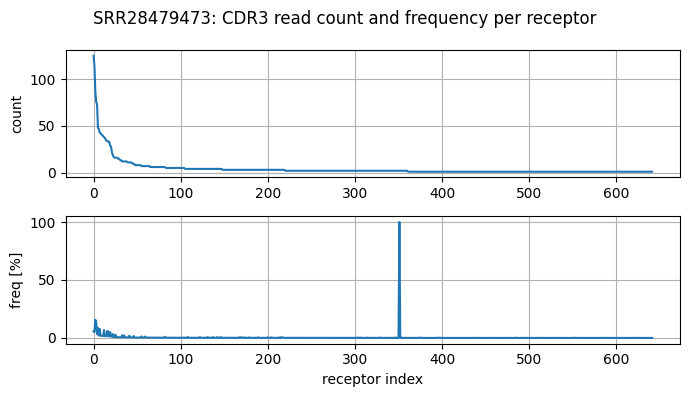

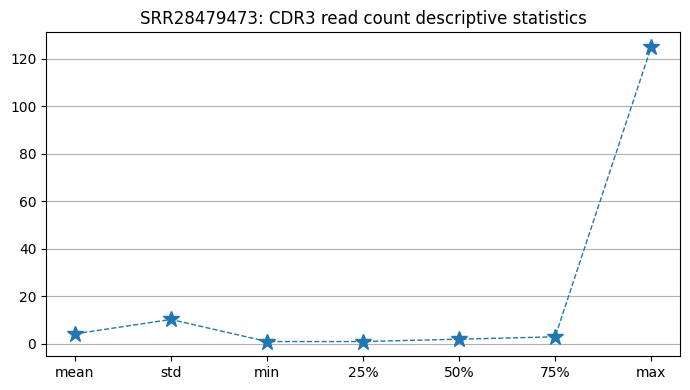

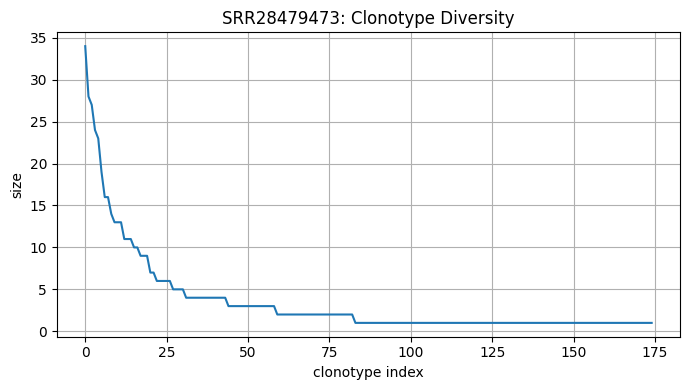

In [ ]:
''' 
Note:
- the frequency (computed as (read count of specific TCR [BCR] CDR3 seq) / (total count of all BCR [TCR] CDR3 seq in the data)) provides imformation
  into the relative abundance of each clonotype within the immune repertoire
'''
figsize: tuple[int, int] = (7,4)
save_figure: bool = False
# -------------------------------
report_file: Path = Path(out_path) / f'TRUST_{sample_name}_report.tsv'
df = pd.read_csv(report_file, sep='\t').rename(columns={'#count': 'count'})
print(f"Report for {sample_name}:")
display(df)

print(f"- {df['cid'].unique().size:,} unique consensus IDs.")

# number of CDR3 sequences found
num_cdr3: int = df['CDR3nt'].unique().size
print(f"- {num_cdr3:,} unique CDR3 sequences found.")

# complete VDJ variable domain
cid_full_length: pd.Series = df['cid_full_length']
print(f"- {100 * cid_full_length.sum() / cid_full_length.size:.1f}% of {cid_full_length.size:,} receptors contain complete variable domain (V(D)J).")

# read_counts and frequency
read_counts: pd.Series = df['count']
frequency: list[float] = list(100 * df['frequency'])
fig, ax = plt.subplots(nrows=2, ncols=1, tight_layout=True, figsize=figsize, squeeze=True)
ax[0].plot(read_counts)
ax[0].grid()
ax[0].set_ylabel('count')

ax[1].plot(frequency)
ax[1].grid()
ax[1].set_ylabel('freq [%]')
ax[1].set_xlabel('receptor index')
fig.suptitle(f'{sample_name}: CDR3 read count and frequency per receptor', fontsize=12)
if save_figure:
    fig_file: Path = figure_path / f"{sample_name}_CDR3_read_counts_and_freq.jpg"
    plt.savefig(fig_file)
    print(f"\nFigure saved in {fig_file}.")

# read count stats
stats = read_counts.describe().drop('count')
stats_verbose = {x: round(v, 1) for x, v in stats.items()}
print(f"- CDR3 read count stats: {stats_verbose}")
fig, ax = plt.subplots(nrows=1, ncols=1, tight_layout=True, figsize=figsize, squeeze=True)
ax.plot(stats.index, list(stats.values), '--*', linewidth=1.0, markersize=12)
ax.set_title(f"{sample_name}: CDR3 read count descriptive statistics", fontsize=12)
ax.yaxis.grid()
if save_figure:
    fig_file: Path = figure_path / f"{sample_name}_CDR3_read_counts_stats.jpg"
    plt.savefig(fig_file)
    print(f"\nFigure saved in {fig_file}.")

# clonotype diversity
df_clonotype = (df[['V', 'J']]
      .query("V != '.' and J != '.'")
      .groupby(by=['V', 'J'])
      .size()
      .to_frame(name='size')
      .sort_values(by='size', ascending=False)
)
print(f"\n{df_clonotype.shape[0]:,} clonotypes:")
display(df_clonotype)

fig, ax = plt.subplots(nrows=1, ncols=1, tight_layout=True, figsize=figsize, squeeze=True)
ax.plot(df_clonotype.values)
ax.grid()
ax.set_xlabel('clonotype index')
ax.set_ylabel('size')
ax.set_title(f"{sample_name}: Clonotype Diversity", fontsize=12)
if save_figure:
    fig_file: Path = figure_path / f"{sample_name}_clonotype_diversity.jpg"
    plt.savefig(fig_file)
    print(f"\nFigure saved in {fig_file}.")


### VDJC genes diversity

- V gene: total of 80 genes: 78 BCR genes and 1 TCR genes
- D gene: total of 27 genes: 26 BCR genes and 0 TCR genes
- J gene: total of 23 genes: 21 BCR genes and 1 TCR genes
- C gene: total of 9 genes: 7 BCR genes and 1 TCR genes


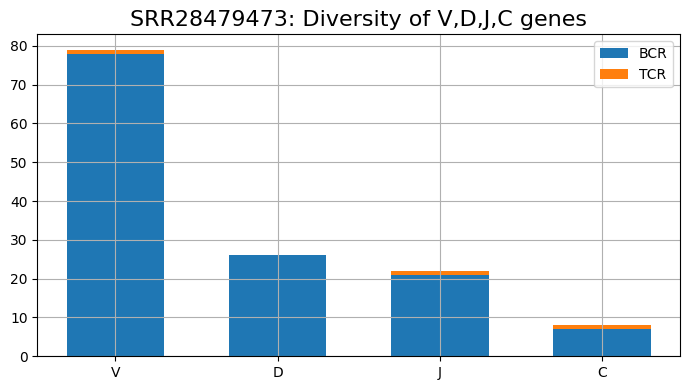

In [93]:
figsize: tuple[int, int] = (7,4)
width: float = 0.6
save_figure: bool = False
# -------------------------------
VDJC_genes_diverisity = defaultdict(list)
for gene in VDJC_genes:
    v_genes = df[gene].unique().tolist()
    v_tcr_genes = [v for v in v_genes if v.startswith('T')]
    v_bcr_genes = [v for v in v_genes if v.startswith('I')]
    print(f"- {gene} gene: total of {len(v_genes)} genes: {len(v_bcr_genes)} BCR genes and {len(v_tcr_genes)} TCR genes")
    VDJC_genes_diverisity['BCR'].append(len(v_bcr_genes))
    VDJC_genes_diverisity['TCR'].append(len(v_tcr_genes))

# plot
fig, ax = plt.subplots(nrows=1, ncols=1, tight_layout=True, figsize=figsize, squeeze=True)
bottom = np.zeros(len(VDJC_genes), dtype=int)

for gene, gene_bcr_tcr_count in VDJC_genes_diverisity.items():
    ax.bar(VDJC_genes, gene_bcr_tcr_count, width, label=gene, bottom=bottom)
    bottom += gene_bcr_tcr_count
ax.grid()
ax.set_title(f"{sample_name}: Diversity of {','.join(VDJC_genes)} genes", fontsize=16)
ax.legend()

if save_figure:
    fig_file: Path = figure_path / f"{sample_name}_VDJC_diversity.jpg"
    plt.savefig(fig_file)
    print(f"\nFigure saved in {fig_file}.")


### CDRs Information

- TRUST_sample_cdr3.out reports the CDR1,2,3 and gene information for each consensus assemblies
- contains both complete and partial CDR3 sequences

,consensus_id,index_within_consensus,V_gene,D_gene,J_gene,C_gene,CDR1,CDR2,CDR3,CDR3_score,read_fragment_count,CDR3_germline_similarity,complete_vdj_assembly
0,assemble0,0,*,*,IGHJ4*02,IGHG1*01,*,*,GCGAGAGTCTGGTTGGTTCGGGGAGTTACCGTTGACTACTGG,0.0,31.00,0.00,0
1,assemble1,0,IGKV4-1*01,*,IGKJ1*01,IGKC*04,CAGAGTGTTTTATACAGCTCCAACAATAAGAACTAC,TGGGCATCT,TGTCAGCAATATTATAGTACGTCGTGGACGTTC,1.0,121.43,100.00,1
2,assemble1,1,IGKV4-1*01,*,IGKJ1*01,IGKC*04,CAGAGTGTTTTATACAGCTCCAACAATAAGAACTAC,TGGGCATCT,TTTCAGCAATATTATAGTACGTCGTGGACGTTC,1.0,5.16,96.43,1
3,assemble1,2,IGKV4-1*01,*,IGKJ1*01,IGKC*04,CAGAGTGTTTTATACAGCTCCAACAATAAGAACTAC,TGGGCATCT,TGTTAGCAATATTATAGTACGTCGTGGACGTTC,1.0,2.58,96.43,1
4,assemble1,3,IGKV4-1*01,*,IGKJ1*01,IGKC*04,CAGAGTGTTTTATACAGCTCCAACAATAAGAACTAC,TGGGCATCT,TGTCAGCAATATTATAGTACGTCGTTCACGTTC,1.0,2.26,92.86,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1624,assemble9275,0,"IGLV1-44*01,IGLV1-36*01,IGLV1-47*01",*,*,*,*,*,TGTGCTGCATGGGATGACACTTTGCATGCCTGGCTCTTC,1.0,1.00,0.00,0
1625,assemble9285,0,*,*,IGHJ3*02,*,*,*,TCGAGTATAAGAACTCCCCCCACTGGTTCTTTTGATATTTGG,0.0,1.00,0.00,0
1626,assemble9296,0,*,*,TRAJ11*01,*,*,*,TGACTGAGTACACATCATATGATAGACTTTATGATATTCAGGATAC...,0.0,1.00,0.00,0
1627,assemble9298,0,"IGKV3-20*01,IGKV3D-20*01",*,*,*,*,*,TGTCACCAGTATGCTGCGTCACCTCGGACC,0.0,1.00,0.00,0


- 1,374 unique consensus IDs
- 17 unique CDR1 sequences.	seq len stats: {'mean': 25.4, 'std': 6.9, 'min': 18.0, '25%': 18.0, '50%': 24.0, '75%': 33.0, 'max': 36.0}
- 38 unique CDR2 sequences.	seq len stats: {'mean': 13.8, 'std': 7.0, 'min': 8.0, '25%': 9.0, '50%': 9.0, '75%': 24.0, 'max': 30.0}
- 1,564 unique CDR3 sequences.	seq len stats: {'mean': 33.5, 'std': 8.4, 'min': 18.0, '25%': 27.0, '50%': 33.0, '75%': 36.0, 'max': 69.0}
- 235 unique V_gene are used
- 27 unique D_gene are used
- 42 unique J_gene are used
- 21 unique C_gene are used


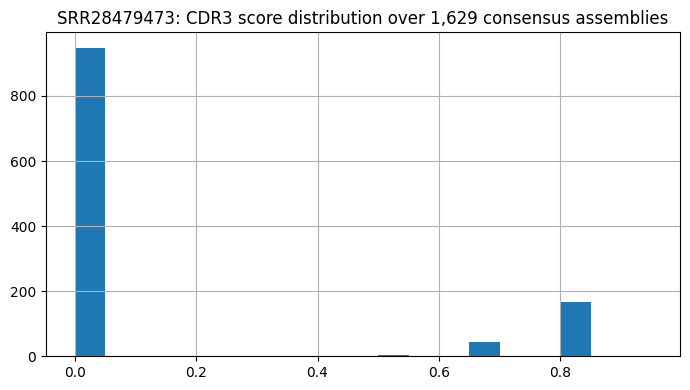

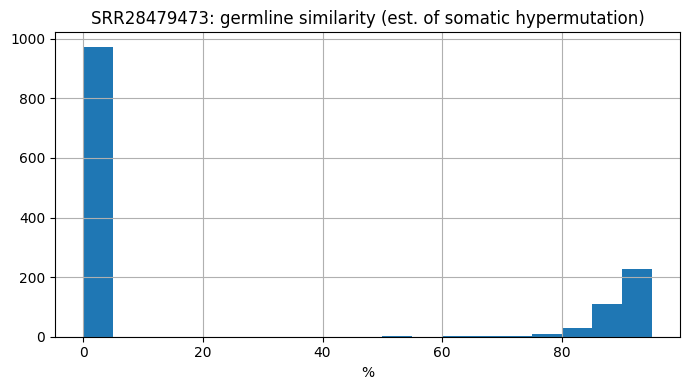

In [94]:
''' 
CDR3 scores stats

Note:
- index_within_consensus: specifies multiple CDR3s within a single consensus sequence.
'''
figsize: tuple[int, int] = (7,4)
save_figure: bool = False
# --------------------------------
cdr3_file: Path = Path(out_path) / f'TRUST_{sample_name}_cdr3.out'
df_cdr3 = pd.read_csv(cdr3_file, sep='\t', names=CDR3_out_cols)
display(df_cdr3)

print(f"- {df_cdr3['consensus_id'].unique().size:,} unique consensus IDs")

cdr3_scores = list(df_cdr3['CDR3_score'])

# plot
fig, ax = plt.subplots(nrows=1, ncols=1, tight_layout=True, figsize=figsize, squeeze=True)

ax.hist(cdr3_scores, bins=list(np.arange(0, 1, 0.05, dtype=float)))
ax.grid()
ax.set_title(f"{sample_name}: CDR3 score distribution over {len(cdr3_scores):,} consensus assemblies", fontsize=12)

if save_figure:
    fig_file: Path = figure_path / f"{sample_name}_CDR3_scores.jpg"
    plt.savefig(fig_file)
    print(f"\nFigure saved in {fig_file}.")
#print("Recall that 0 score implies partial CDR3.")

# somatic hypermutation
CDR3_germline_similarity: list[float] = df_cdr3['CDR3_germline_similarity'].tolist()
fig, ax = plt.subplots(nrows=1, ncols=1, tight_layout=True, figsize=figsize, squeeze=True)
ax.hist(CDR3_germline_similarity, bins=list(np.arange(0, 100, 5, dtype=float)))
ax.grid()
ax.set_title(f"{sample_name}: germline similarity (est. of somatic hypermutation)", fontsize=12)
ax.set_xlabel('%')

if save_figure:
    fig_file: Path = figure_path / f"{sample_name}_sgermline_similarity.jpg"
    plt.savefig(fig_file)
    print(f"\nFigure saved in {fig_file}.")

# CDR3 sequence length distributions
# Note: CDR3 sequence varies in each assembly
CDRs_seq_cols: list[str] = ['CDR1', 'CDR2', 'CDR3']
for cdr_col in CDRs_seq_cols:
    cdr_seqs = df_cdr3[cdr_col]
    cdr_seq_lens = cdr_seqs.apply(len)
    cdr_seq_lens = cdr_seq_lens[cdr_seq_lens>1]
    stats = cdr_seq_lens.describe().drop('count')
    stats_verbose = {x: round(v, 1) for x, v in stats.items()}
    print(f"- {cdr_seqs.unique().size:,} unique {cdr_col} sequences.\tseq len stats: {stats_verbose}")

# genes usage
for gene in [f"{g}_gene" for g in VDJC_genes]:
    print(f"- {df_cdr3[gene].unique().size:,} unique {gene} are used")


## Results Summary

**<u>SRR28479473</u>**
- 638 unique CDR3 sequences found
- CDR3 seq len stats: {'mean': 33.5, 'std': 8.4, 'min': 18.0, '25%': 27.0, '50%': 33.0, '75%': 36.0, 'max': 69.0}
- 4.0% of the 642 receptors contain complete variable domain (V(D)J)
- CDR3 read count stats: {'mean': 4.2, 'std': 10.3, 'min': 1.0, '25%': 1.0, '50%': 2.0, '75%': 3.0, 'max': 125.0}
- V gene: total of 80 genes: 78 BCR genes and 1 TCR genes
- D gene: total of 27 genes: 26 BCR genes and 0 TCR genes
- J gene: total of 23 genes: 21 BCR genes and 1 TCR genes
- C gene: total of 9 genes: 7 BCR genes and 1 TCR genes
- 17 unique CDR1 sequences.	seq len stats: {'mean': 25.4, 'std': 6.9, 'min': 18.0, '25%': 18.0, '50%': 24.0, '75%': 33.0, 'max': 36.0}
- 38 unique CDR2 sequences.	seq len stats: {'mean': 13.8, 'std': 7.0, 'min': 8.0, '25%': 9.0, '50%': 9.0, '75%': 24.0, 'max': 30.0}


**<u>SRR28479474</u>**

**<u>SRR28479475</u>**




# Miscellaneous

## Download GEO Samples

1. Go to the GEO [Dataset](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE262648)
1. Click on a sample from the Samples row (e.g., GSM8172959)
1. Click on the SRA accession number at the bottom (under `Relations`). This will open the corresponding SRA page. Copy the corresponding SRA run accession (e.g. `SRR28479474`).


In [ ]:
# This should move to a ./Util/utils.py file

class SRAtoolkit():
    """SRA toolkit Interface"""
    def __init__(self, sra_accession: str, folder: Path, sratoolkit_bin_folder: Path = Path('./Tools/sratoolkit.3.2.1/bin')) -> None:
        """
        Args:
            sra_accession (str): the SRA run accession number (e.g. SRR28479474)
            folder (Path): destination folder (will hold .sra, .sam or .fastaq)
            sratoolkit_bin_folder (Path, optional): path to sratoolkit bin/ folder. Defaults to Path('./Tools/sratoolkit.3.2.1/bin').
        """
        self.sra_accession: str = sra_accession
        self.folder: Path = folder
        self.sratoolkit_bin_folder: Path = sratoolkit_bin_folder
        self.sra_file: Path = folder / f"{sra_accession}.sra"

    def stats(self) -> str:
        """Returns the stats of the accession in XML formatted string"""
        command: str = f"{self.sratoolkit_bin_folder}/sra-stat -x {self.sra_accession}"
        try:
            ret, stdout, stderr = run_command(command)
        except subprocess.CalledProcessError as e:
            print(f"stats failed: {e}")
            print(f"Error output: {e.stderr}")
        return stdout
    
    def info(self) -> str:
        command: str = f"{self.sratoolkit_bin_folder}/vdb-dump --info {self.sra_accession}"
        try:
            ret, stdout, stderr = run_command(command)
        except subprocess.CalledProcessError as e:
            print(f"info failed: {e}")
            print(f"Error output: {e.stderr}")
        return stdout

    def prefetch(self) -> CommandOut:
        command: str = f"{self.sratoolkit_bin_folder}/prefetch -o {self.sra_file} {self.sra_accession}"
        try:
            ret, stdout, stderr = run_command(command)
        except subprocess.CalledProcessError as e:
            print(f"prefetch failed: {e}")
            print(f"Error output: {e.stderr}")
        return ret, stdout, stderr 
    
    def gen_fastaq(self, temp_folder: Path | None = None) -> CommandOut:
        if temp_folder is None:
            temp_folder = self.folder
        command: str = f"{self.sratoolkit_bin_folder}/fasterq-dump {self.sra_file} -t {temp_folder} -O {self.folder}"
        try:
            ret, stdout, stderr = run_command(command)
        except subprocess.CalledProcessError as e:
            print(f"generating fastaq failed: {e}")
            print(f"Error output: {e.stderr}")
        return ret, stdout, stderr
    
    def gen_bam(self, samtools_exe: str, remove_sam: bool = True) -> tuple[CommandOut, CommandOut]:
        # gen the sam file
        sam_file = self.sra_file.with_suffix('.sam')
        command: str = f"{self.sratoolkit_bin_folder}/sam-dump {self.sra_file} > {sam_file}"
        try:
            rets, stdouts, stderrs = run_command(command)
        except subprocess.CalledProcessError as e:
            print(f"generating sam failed: {e}")
            print(f"Error output: {e.stderr}")

        # convert to bam
        bam_file = sam_file.with_suffix('.bam')
        command: str = f"{samtools_exe} view -bS {sam_file} > {bam_file}"
        try:
            retb, stdoutb, stderrb = run_command(command)
        except subprocess.CalledProcessError as e:
            print(f"generating bam failed: {e}")
            print(f"Error output: {e.stderr}")

        # remove sam
        if remove_sam:
            sam_file.unlink()

        return (rets, stdouts, stderrs), (retb, stdoutb, stderrb)

    def cleanup(self) -> None:
        if self.sra_file.is_file():
            self.sra_file.unlink()

    def prefetch_bam(self, samtools_exe: str, remove_sam: bool = True) -> None:
        """Wrapper to prefetch and gen_bam"""
        self.prefetch()
        self.gen_bam(samtools_exe, remove_sam=remove_sam)
        self.cleanup()

    def prefetch_fastaq(self, temp_folder: Path | None = None) -> None:
        """Wrapper to prefetch and gen_fastaq"""
        self.prefetch()
        self.gen_fastaq(temp_folder=temp_folder)
        self.cleanup()

    def __repr__(self) -> str:
        return f"SRAtoolkit('{self.sra_accession}', '{self.folder}')"

    def __str__(self) -> str:
        return "SRA toolkit interface.\n"


In [ ]:
''' 
Fetch a sample and generate the bam/fastaq files.
'''
sra_sample_accession: str = 'SRR28479473'  # run accession number
# ----------------------------------------------------------------
srat = SRAtoolkit(sra_sample_accession, Path(data_path))

aligned = 'align' in srat.info()
print(f"{sra_sample_accession} contains {'aligned' if aligned else 'un-aligned'} data.")

# prefetch
ret, stdout, stderr = srat.prefetch()
print(ret, stdout, stderr)

if aligned:
    # generate bam
    (rets, stdouts, stderrs), (retb, stdoutb, stderrb) = srat.gen_bam(samtools_path)
    print(rets, stdouts, stderrs, retb, stdoutb, stderrb)
else:
    # generate fastaq
    ret, stdout, stderr = srat.gen_fastaq()
    print(ret, stdout, stderr)

srat.cleanup()

# History and Old Stuff

Things we tried:

1. To download the sample (e.g., `SRR28479474`), use the SRA toolkit as follows:

    1. `prefetch SRR28479474`(or `prefetch SRX24082038`) - this downloads the sample in a `.sra` format
    1. if the sample is not alligned (as in this case), perform: `fasterq-dump.3.2.1 ./SRR28479474 -t ./temp -O ./SRR28479474` - this will generate the fastaq file(s)
    1. if the sample is aligned, perform `sam-dump.3.2.1 ./SRR28479474/SRR28479474.sra > ./SRR28479474/SRR28479474.sam` and then generate the BAM file by executing `samtools view -bS ./SRR28479474/SRR28479474.sam > ./SRR28479474/SRR28479474.bam`

1. dataset from Immunophenotyping of COVID-19 and Influenza Underscores the Association of Type I IFN Response in Severe COVID-19 in [GEO](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE149689): 

From the downloaded folder execute:
1. ./bin/prefetch SRX8241106 --max-size 30G

Resulted with:
```console
2025-03-31T13:15:00 prefetch.3.2.1: 1) Resolving 'SRX8241106'...
2025-03-31T13:15:03 prefetch.3.2.1: Current preference is set to retrieve SRA Normalized Format files with full base quality scores
2025-03-31T13:15:03 prefetch.3.2.1: 1) Downloading 'SRR11680207'...
2025-03-31T13:15:03 prefetch.3.2.1:  SRA Normalized Format file is being retrieved
2025-03-31T13:15:03 prefetch.3.2.1:  Downloading via HTTPS...
2025-03-31T13:52:10 prefetch.3.2.1:  HTTPS download succeed
2025-03-31T13:52:10 prefetch.3.2.1:   verifying 'SRR11680207'...
2025-03-31T13:52:57 prefetch.3.2.1:  'SRR11680207' is valid: 29607783613 bytes were streamed from 29607781179
2025-03-31T13:52:57 prefetch.3.2.1: 1) 'SRR11680207' was downloaded successfully
2025-03-31T13:52:57 prefetch.3.2.1: 1) Resolving 'SRX8241106's dependencies...
2025-03-31T13:52:57 prefetch.3.2.1: 'SRX8241106' has 0 unresolved dependencies
```

1. then generate the fastaq files: ./bin/fasterq-dump.3.2.1 ./SRR11680207 -t ./temp -O ./SRR11680207

resulted in:
```console
spots read      : 722,551,560
reads read      : 1,445,103,120
reads written   : 1,445,103,120
```

Running on the two fastaq files:
```python
fastq_1_file = 'SRR11680207_1.fastq'
fastq_2_file = 'SRR11680207_2.fastq'

num_threads: int = 8
# -----------------------
ret, stdout, stderr = trust4c.run_paired_fastaq(VDJC_gene_ref_file.name, bcr_tcr_gene_seq_file.name, fastq_1_file, fastq_2_file, extra_params=f" -t {num_threads}")
print(ret, stdout, stderr, sep='\n')
```

Resulted in:
```console
Mon Mar 31 16:43:23 2025] TRUST4 v1.1.5-r573 begins.
[Mon Mar 31 16:43:23 2025] SYSTEM CALL: /usr/local/bin/fastq-extractor -t 8 -f /ref/bcrtcr.fa -o /out/TRUST_SRR11680207_1_toassemble  -1 /data/SRR11680207_1.fastq -2 /data/SRR11680207_2.fastq
[Mon Mar 31 16:43:23 2025] Start to extract candidate reads from read files.
system /usr/local/bin/fastq-extractor -t 8 -f /ref/bcrtcr.fa -o /out/TRUST_SRR11680207_1_toassemble  -1 /data/SRR11680207_1.fastq -2 /data/SRR11680207_2.fastq failed: 9 at /usr/local/bin/run-trust4 line 60
```

Tried also to create the BAM file:
1. ./bin/sam-dump.3.2.1 ./SRR11680207/SRR11680207.sra > ./SRR11680207/SRR11680207.sam
1. samtools view -bS ./SRR11680207/SRR11680207.sam > ./SRR11680207/SRR11680207.bam

And then running on the BAM file resulted in a similar error.

Try now https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE262648:
1. ./bin/prefetch SRR28479475
1. ./bin/sam-dump.3.2.1 ./SRR28479475/SRR28479475.sra > ./SRR28479475/SRR28479475.sam
1. samtools view -bS ./SRR28479475/SRR28479475.sam > ./SRR28479475/SRR28479475.bam

In [ ]:
# geo_sample_accession: str = 'SRR28479473'  # run accession number
# sra_sample_type: str = 'fastaq'  # set to 'fastaq' or 'sam' based on the sample type
# # ------------------------------------------------------------------------------------
# assert sra_sample_type in {'sam', 'fastaq'}, f"{sra_sample_type} should be either sam or fastaq !!"
# sra_file: str = f"{data_path}/{geo_sample_accession}.sra"
 
# # prefetch the data
# command: str = f"{sra_command_path}/prefetch -o {sra_file} {geo_sample_accession}"
# print(f"Fetching {geo_sample_accession} data ...")
# ret, stdout, stderr = run_command(command)
# print(ret, stdout, stderr)

# match sra_sample_type:
#     case 'sam':
#         sam_file = Path(sra_file).with_suffix('.sam')
#         print("Creating the SAM file ...")
#         command: str = f"{sra_command_path}/sam-dump.3.2.1 {sra_file} > {sam_file}"
#         ret, stdout, stderr = run_command(command)
#         print(ret, stdout, stderr)
        
#         print("Converting to BAM ...")
#         command: str = f"samtools view -bS {sam_file} > {sam_file.with_suffix('.bam')}"
#         ret, stdout, stderr = run_command(command)
#         print(ret, stdout, stderr)

#         print("Removing the sam file ...")
#         !rm {sam_file}
#     case 'fastaq':
#         print("Creating the fastaq file ...")
#         command: str = f"{sra_command_path}/fasterq-dump.3.2.1 {sra_file} -t {data_path} -O {data_path}"
#         ret, stdout, stderr = run_command(command)
#         print(ret, stdout, stderr)
#     case _:
#         raise ValueError(f"Unknown {sra_sample_type=} !!")

# # remove the SRA file
# print(f"Removing {sra_file}...")
# !rm {sra_file}